<a href="https://colab.research.google.com/github/AkarisDimitry/VASP/blob/master/ORR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import logging, functools, time, datetime
logger = logging.getLogger('decorator-log')
logger.setLevel(logging.DEBUG)

# create console handler and set level to debug
ch = logging.StreamHandler()
ch.setLevel(logging.DEBUG)

# create formatter
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')

# add formatter to ch
ch.setFormatter(formatter)

# add ch to logger
logger.addHandler(ch)
# disable logging on the standard error stream
logger.disabled = False  

class LogDecorator(object):
    def __init__(self):
        self.logger = logging.getLogger('decorator-log')
        self.log_debug_file     = 'log_debug.dat'
        self.log_exception_file = 'log_exception.txt'
        self.debug = False

    def __call__(self, fn):
        @functools.wraps(fn)
        def decorated(*args, **kwargs):
            try:
                # .{fn.__name__}
                msj = f'>> {fn.__module__}.{fn.__qualname__}(): >> called with >>{args} - {kwargs}'
                self.logger.debug(msj)
                self.append_log_to_file(self.log_debug_file, msj )
                before = time.time()
                result = fn(*args, **kwargs)
                #self.logger.debug(result)
                msj = f'>> {fn.__module__}.{fn.__qualname__}(): >> execution time: {time.time()-before} (s)'
                self.logger.debug(msj)
                return result
            except Exception as ex:
                msj = f"Exception raised in >> {fn.__module__}.{fn.__qualname__}(): >> exception: {str(ex)}\n"
                self.logger.debug(msj)
                self.append_log_to_file(self.log_exception_file, msj )
                raise ex
            return result
        return decorated

    def append_log_to_file(self, file, message: str) -> None:
        log_file = open(file, 'a')
        log_file.write(f'>> {datetime.datetime.now()} >> {message}\n')
        log_file.close()

    def reset_log_file(self):
        log_file = open(file, 'w+')
        log_file.write('')
        log_file.close()
        

In [5]:
###################################
#  Load python libraries 		  #
###################################
# *** warning supresion
import warnings
warnings.filterwarnings("ignore")

try:
	from os import path
	import itertools, operator, logging, time, copy, pickle, os.path
except:  print('ERROR :: DATA.import_libraries() :: can not import itertools, operator, logging, time, copy, pickle or os')

try:
	import numpy as np
except: print('ERROR :: DATA.import_libraries() :: can not import numpy ')

try:
	import matplotlib.pyplot as plt
	import matplotlib.axes as ax
	import matplotlib.patches as patches
except:	print('ERROR :: DATA.import_libraries() :: can not import matplotlib ')

from scipy.signal import savgol_filter

try:
	from sklearn.decomposition import PCA
	from sklearn.preprocessing import StandardScaler
	from sklearn import linear_model
	from sklearn.model_selection import cross_val_predict
	from sklearn.metrics import mean_squared_error, r2_score
except:	print('ERROR :: DATA.import_libraries() :: can not import sklearn')

try:
	from ase import Atoms
	from ase.visualize import view
except:	print('ERROR :: DATA.import_libraries() :: can not import ase ')

ERROR :: DATA.import_libraries() :: can not import ase 


In [6]:

class OxigenReaction(object):
	def __init__(self, name='Oxigen_Reaction', 	sys=None, sys_O=None, sys_OH=None, sys_OOH=None, sys_O2=None, 
												H2O=None, H2=None, T=None):
		self.name = 'Oxigen_Reaction'
		self.system = {}

		self.sys 		= sys
		self.sys_O 		= sys_O
		self.sys_OH 	= sys_OH
		self.sys_OOH	= sys_OOH
		self.sys_O2	 	= sys_O2

		self.H2O	=	H2O
		self.H2 	=	H2

		self.T = T 
		self.kb = 8.617*10**-5 # eV K-1

		self.ORR = None

		self.color 	= [ 	
			'#DC143C', # 	crimson 			#DC143C 	(220,20,60)
			'#ADFF2F', #	green yellow 		#ADFF2F 	(173,255,47)
			'#40E0D0', #	turquoise 			#40E0D0 	(64,224,208)
			'#FF8C00', #  	dark orange 		#FF8C00 	(255,140,0)
			'#BA55D3', #	medium orchid 		#BA55D3 	(186,85,211)
			'#1E90FF', #	dodger blue 		#1E90FF 	(30,144,255)
			'#FF1493', #	deep pink 			#FF1493 	(255,20,147)
			'#8B4513', #	saddle brown 		#8B4513 	(139,69,19)
			'#FFD700', #	gold 				#FFD700 	(255,215,0)
			'#808000', #	Olive 				#808000 	(128,128,0)
			'#808080', #	Gray 				#808080 	(128,128,128)
			'#FF00FF', #	Magenta / Fuchsia 	#FF00FF 	(255,0,255)
			'#00FFFF', #	Cyan / Aqua 		#00FFFF 	(0,255,255)
			'#000000', #	Black 				#000000 	(0,0,0)
							# ------- REPEAT -------- #
			'#DC143C', # 	crimson 			#DC143C 	(220,20,60)
			'#ADFF2F', #	green yellow 		#ADFF2F 	(173,255,47)
			'#40E0D0', #	turquoise 			#40E0D0 	(64,224,208)
			'#FF8C00', #  	dark orange 		#FF8C00 	(255,140,0)
			'#BA55D3', #	medium orchid 		#BA55D3 	(186,85,211)
			'#1E90FF', #	dodger blue 		#1E90FF 	(30,144,255)
			'#FF1493', #	deep pink 			#FF1493 	(255,20,147)
			'#8B4513', #	saddle brown 		#8B4513 	(139,69,19)
			'#FFD700', #	gold 				#FFD700 	(255,215,0)
			'#808000', #	Olive 				#808000 	(128,128,0)
			'#808080', #	Gray 				#808080 	(128,128,128)
			'#FF00FF', #	Magenta / Fuchsia 	#FF00FF 	(255,0,255)
			'#00FFFF', #	Cyan / Aqua 		#00FFFF 	(0,255,255)
			'#000000', #	Black 				#000000 	(0,0,0)
			]

	def calculate(self,	sys=None, sys_O=None, sys_OH=None, sys_OOH=None, sys_O2=None, 
						H2O=None, H2=None, T=298, Gb=0, thermodimanic_corrections=True, v=False):
		# (Lee) 	S= {'sys':0, 'O':0.05, 'OH':0.07, 'OOH':0.16, 'O2':0.00, 'H2':0.41, 'H2O':0.67}
		# (Norskov) S= {'sys':0, 'O':0.00, 'OH':0.00, 'OOH':0.00, 'O2':0.00, 'H2':0.41, 'H2O':0.67}
		
		if type(sys) == type(None): sys = self.sys
		if type(sys) == type(None) and v: print('ERROR :: OxigenReaction.calculate() :: can not import sys ')
		  
		if type(sys_O) == type(None): sys_O = self.sys_O
		if type(sys_O) == type(None) and v: print('ERROR :: OxigenReaction.calculate() :: can not import sys_O ')
		  
		if type(sys_OH) == type(None): sys_OH = self.sys_OH
		if type(sys_OH) == type(None) and v: print('ERROR :: OxigenReaction.calculate() :: can not import sys_OH ')
		  
		if type(sys_OOH) == type(None): sys_OOH = self.sys_OOH
		if type(sys_OOH) == type(None) and v: print('ERROR :: OxigenReaction.calculate() :: can not import sys_OOH ')
		  
		if type(sys_O2) == type(None): sys_O2 = self.sys_O2
		if type(sys_O2) == type(None) and v: print('ERROR :: OxigenReaction.calculate() :: can not import sys_O2 ')
		  
		if type(H2) == type(None): H2 = self.H2
		if type(H2) == type(None) and v: print('ERROR :: OxigenReaction.calculate() :: can not import H2 ')

		if type(H2O) == type(None): H2O = self.H2O
		if type(H2O) == type(None) and v: print('ERROR :: OxigenReaction.calculate() :: can not import H2O ')  
		  
		self.result = self.reation( 	E={'*':sys, '*O':sys_O, '*OH':sys_OH, '*OOH':sys_OOH, '*O2':sys_O2, 'H2':H2, 'H2O':H2O}, T=T, v=False, save=True, 
						Gb=Gb, thermodimanic_corrections=thermodimanic_corrections )

		return self.result 

	def reation(self, E={'*':0, '*O':0, '*OH':0, '*OOH':0, 'H2':0, 'H2O':0, '*O2':0}, T=298, 
				v=False, save=True, thermodimanic_corrections=True, Gb=1.6, table=True):
		if T == None: T = 298
		self.T = T
		# (Lee) 	S= {'sys':0, 'O':0.05, 'OH':0.07, 'OOH':0.16, 'O2':0.00, 'H2':0.41, 'H2O':0.67}
		# (Norskov) S= {'sys':0, 'O':0.00, 'OH':0.00, 'OOH':0.00, 'O2':0.00, 'H2':0.41, 'H2O':0.67}
		# (Norskov) ZPE= {'sys':0, 'O':0.07, 'OH':0.30, 'OOH':0.00, 'O2':0.00, 'H2':0.41, 'H2O':0.67}

		TC = 1 if thermodimanic_corrections else 0

		# ==== E(*O2) ==== # # ==== E(*O2) ==== # # ==== E(*O2) ==== #
		try:
			E_O2 	=	E['*O2']['E']			if type(E['*O2']) == dict else  E['*O2'].OSZICAR.ionic_step[-1][2]
			ZPW_O2 	= 	E['*O2']['ZPE']	* TC	if type(E['*O2']) == dict else  E['*O2'].ZPE * TC
			S_O2 	=	E['*O2']['S']/T * TC	if type(E['*O2']) == dict else  E['*O2'].S/T * TC	
		except: 
			if v: print('WARNNING :: can not calculate *O2 free energy (dG_*O2)')
			else: pass

		# ==== E(H2O) ==== # # ==== E(H2O) ==== # # ==== E(H2O) ==== #
		try:
			E_H2Ol 	=	E['H2O']['E']			if type(E['H2O']) == dict else  E['H2O'].OSZICAR.ionic_step[-1][2]
			ZPW_H2Ol= 	E['H2O']['ZPE']	* TC	if type(E['H2O']) == dict else  E['H2O'].ZPE * TC
			S_H2Ol 	=	E['H2O']['S']/T * TC	if type(E['H2O']) == dict else  E['H2O'].S/T * TC	
		except: return None

		try:
			E_H2Og 	=	E['H2O']['E']			if type(E['H2O']) == dict else  E['H2O'].OSZICAR.ionic_step[-1][2]
			ZPW_H2Og= 	E['H2O']['ZPE']	* TC	if type(E['H2O']) == dict else  E['H2O'].ZPE * TC
			S_H2Og 	=	E['H2O']['S']/T * TC	if type(E['H2O']) == dict else  E['H2O'].S/T * TC	
		except: return None

		# ==== E(*) ==== # # ==== E(*) ==== # # ==== E(*) ==== #
		try:
			E_0 	=	E['*']['E']			if type(E['*']) == dict else  E['*'].OSZICAR.ionic_step[-1][2]
			ZPW_0	= 	E['*']['ZPE']* TC	if type(E['*']) == dict else  E['*'].ZPE * TC
			S_0 	=	E['*']['S']/T* TC	if type(E['*']) == dict else  E['*'].S/T * TC	
		except: return None

		# ==== E(O*) ==== # # ==== E(O*) ==== # # ==== E(O*) ==== #
		try:
			E_O 	=	E['*O']['E']		if type(E['*O']) == dict else  E['*O'].OSZICAR.ionic_step[-1][2]
			ZPW_O	= 	E['*O']['ZPE']* TC	if type(E['*O']) == dict else  E['*O'].ZPE * TC
			S_O 	=	E['*O']['S']/T* TC	if type(E['*O']) == dict else  E['*O'].S/T * TC	
		except: return None

		# ====  E(OH*) ====  # # ====  E(OH*) ====  # # ====  E(OH*) ====  #
		try:
			E_OH 	=	E['*OH']['E']		if type(E['*OH']) == dict else  E['*OH'].OSZICAR.ionic_step[-1][2]
			ZPW_OH	= 	E['*OH']['ZPE']* TC	if type(E['*OH']) == dict else  E['*OH'].ZPE * TC
			S_OH 	=	E['*OH']['S']/T* TC if type(E['*OH']) == dict else  E['*OH'].S/T * TC	
		except: return None

		# ==== E(OOH*) ==== # # ==== E(OOH*) ==== # # ==== E(OOH*) ==== #
		try:
			E_OOH 	=	E['*OOH']['E']		 if type(E['*OOH']) == dict else  E['*OOH'].OSZICAR.ionic_step[-1][2]
			ZPW_OOH	= 	E['*OOH']['ZPE']* TC if type(E['*OOH']) == dict else  E['*OOH'].ZPE * TC
			S_OOH 	=	E['*OOH']['S']/T* TC if type(E['*OOH']) == dict else  E['*OOH'].S/T * TC	
		except: return None

		# ==== E(H2) ==== # # ==== E(H2) ==== # # ==== E(H2) ==== #
		try:
			E_H2 	=	E['H2']['E']		if type(E['H2']) == dict else  E['H2'].OSZICAR.ionic_step[-1][2]
			ZPW_H2	= 	E['H2']['ZPE']* TC 	if type(E['H2']) == dict else  E['H2'].ZPE * TC
			S_H2 	=	E['H2']['S']/T* TC 	if type(E['H2']) == dict else  E['H2'].S/T * TC	
		except: return None
		
		dG_experimental = 4.92

		# ==== MU_O2 ****** # # ==== MU_O2 ****** # # ==== MU_O2 ****** # 
		mu_O2  = dG_experimental + 2*(E_H2Ol+ZPW_H2Ol-T*S_H2Ol) - 2*(E_H2+ZPW_H2-T*S_H2)
		if v: print('mu_O2 : ', mu_O2)

		# ==== MU_H2O ==== # # ==== MU_H2O ==== # # ==== MU_H2O ==== #
		mu_h2o = E_H2Ol+ZPW_H2Ol-T*S_H2Ol
		if v: print('E_H2Ol : ', E_H2Ol, 'mu_h2o : ', E_H2Ol)

		# ==== Eabs OH ==== # # ==== Eabs OH ==== # # ==== Eabs OH ==== #
		if v: print(' *** Absortion ENERGIES *** ')
		# OH Absortion energies calculation 
		#Eabs_OH  = E_OH  - E_* - ( E_H2O - 1/2 E_H2)
		Eabs_OH  = E_OH  - E_0 - ( E_H2Ol - 1/2 * E_H2)
		if v: print('Eabs_OH : {:0.2f}'.format(Eabs_OH))
		#Gabs_OH  = G_OH  - G_* - ( G_H2O - 1/2 G_H2)
		Gabs_OH  = (E_OH+ZPW_OH-T*S_OH)  - (E_0) - ( (E_H2Ol+ZPW_H2Ol-T*S_H2Ol) - 1/2 * (E_H2+ZPW_H2-T*S_H2))
		if v: print('Gabs_OH : {:0.2f}'.format(Gabs_OH))

		# ==== Eabs O ==== # # ==== Eabs O ==== # # ==== Eabs O ==== #
		# O Absortion energies calculation 
		#Eabs_O   = E_O   - E_* - ( E_H2O -     E_H2)
		Eabs_O   = E_O   - E_0 - ( E_H2Ol -     E_H2)
		if v: print('Eabs_O : {:0.2f}'.format(Eabs_O))
		#Gabs_O   = G_O   - G_* - ( G_H2O -     E_H2)
		Gabs_O   = (E_O+ZPW_O-T*S_O)   - E_0 - ( (E_H2Ol+ZPW_H2Ol-T*S_H2Ol)	 -  (E_H2+ZPW_H2-T*S_H2))
		if v: print('Gabs_O : {:0.2f}'.format(Gabs_O))

		# ==== Eabs OOH ==== # # ==== Eabs OOH ==== # # ==== Eabs OOH ==== #
		# OOH Absortion energies calculation 
		#Eabs_OOH = E_OOH - E_* - (2E_H2O - 2/3 E_H2)
		Eabs_OOH = E_OOH - E_0 - (2 * E_H2Ol - 3/2 * E_H2)
		if v: print('Eabs_OOH : {:0.2f}'.format(Eabs_OOH))
		#Gabs_OOH = G_OOH - G_* - (2G_H2O - 2/3 G_H2)
		Gabs_OOH = (E_OOH+ZPW_OOH-T*S_OOH) - E_0 - (2 * (E_H2Ol+ZPW_H2Ol-T*S_H2Ol) - 3/2 * (E_H2+ZPW_H2-T*S_H2))
		if v: print('Gabs_OOH : {:0.2f}'.format(Gabs_OOH))

		# ==== mu_e - mu_OH ==== # # ==== mu_e - mu_OH ==== # # ==== mu_e - mu_OH ==== #
		K = -1/4 * (mu_O2 + 2*mu_h2o + Gb)
		if v: print('K = mu_e - mu_OH - eU : ',K)

		# ==== dG ==== # # ==== dG ==== # # ==== dG ==== #
		# dG1 = G_OH - G_* + K
		dG1 = (E_OH+ZPW_OH-T*S_OH) - (E_0+ZPW_0-T*S_0) + K 
		# dG2 = G_O + mu_H2O - G_OH + K
		dG2 = (E_O+ZPW_O-T*S_O)+(E_H2Ol+ZPW_H2Ol-T*S_H2Ol)-(E_OH+ZPW_OH-T*S_OH)+ K 
		# dG3 = G_OOH - G_O + K
		dG3 = (E_OOH+ZPW_OOH-T*S_OOH)-(E_O+ZPW_O-T*S_O)+ K 
		# dG4 = G_* + mu_O2 + G_H2O - G_OOH + K
		dG4 = (E_0+ZPW_0-T*S_0)+(E_H2Og+ZPW_H2Og-T*S_H2Og)+ mu_O2 -  (E_OOH+ZPW_OOH-T*S_OOH) + K

		# *** dG ORR 2e *** (basic medium)
		dG1_2e = ((E_OOH+ZPW_OOH-T*S_OOH) - (E_0+ZPW_0-T*S_0)) - mu_O2 - 0.5 * (E_H2+ZPW_H2-T*S_H2) + 0.5*1.4066
		dG2_2e = -dG1_2e

		overpotencial_OER = np.amax([dG4, dG3, dG2, dG1])
		overpotencial_ORR = np.amax([-dG1,-dG2,-dG3,-dG4])

		overpotencial_OER_22 = np.amax( np.array([ dG1+dG2,  dG3+dG4]))
		overpotencial_ORR_22 = np.amax( np.array([-dG4-dG3, -dG2-dG1]))

		overpotencial_OER_2 = np.amax( np.array([ dG2_2e,  dG1_2e]))
		overpotencial_ORR_2 = np.amax( np.array([ dG1_2e,  dG2_2e]))
					
		# sum = 4*9.650 + 4.92 + 4*(E_H2Og+ZPW_H2Og-T*S_H2Og) - 2*(E_H2+ZPW_H2-T*S_H2)
		if v: 
			print('dG1_OER: {} \n dG2_OER: {} \n dG3_OER: {} \n dG4_OER: {} '.format(  dG1,  dG2,  dG3,  dG4) )
			print('dG1_ORR: {} \n dG2_ORR: {} \n dG3_OERR: {} \n dG4_ORR: {} '.format(-dG4, -dG3, -dG2, -dG1) )
			print('SUM :: ', 4*K + 4.92 + 4*(E_H2Og+ZPW_H2Og-T*S_H2Og) - 2*(E_H2+ZPW_H2-T*S_H2) )
			print('OER overpotencial', np.amax([dG1,dG2,dG3,dG4]) )
			print('OER limitind step dG', 1+np.argmax( np.array([dG1, dG2, dG3, dG4])  ))
			print('ORR overpotencial',np.amax([-dG1,-dG2,-dG3,-dG4]) )
			print('ORR limitind step dG', 1+np.argmax( np.array([-dG4, -dG3, -dG2, -dG1])  ))

		if save: # ---------- SAVE all calculation ---------- # 
			# --- OVER POTENCIAL --- #
				# - 4e - #
			self.overpotencial_OER_4e = overpotencial_OER
			self.overpotencial_ORR_4e = overpotencial_ORR
				# - 2e2e - #
			self.overpotencial_OER_2e2e = overpotencial_OER_22
			self.overpotencial_ORR_2e2e = overpotencial_ORR_22	
				# - 2e - #
			self.overpotencial_OER_2e = overpotencial_OER_2
			self.overpotencial_ORR_2e = overpotencial_ORR_2	

			# --- dG FREE ENERGY CHANGE reactions --- #
				# - 4e - #
			self.dG_OER_4e = np.array([ dG1,  dG2,  dG3,  dG4,])
			self.dG_ORR_4e = np.array([-dG4, -dG3, -dG2, -dG1,])
				# - 2e2e - #
			self.dG_OER_2e2e = np.array([ dG1+dG2,  dG3+dG4,])
			self.dG_ORR_2e2e = np.array([-dG4-dG3, -dG2-dG1,])
				# - 2e - #
			self.dG_OER_2e2e = np.array([-dG2_2e,  -dG1_2e])
			self.dG_ORR_2e2e = np.array([ dG1_2e,   dG2_2e])

			# --- STEP FREE ENERGY --- #
			self.G_OER_4e = np.array([0,  dG1 ,   dG1+dG2,    dG1+dG2+dG3,    dG1+dG2+dG3+dG4 ])
			self.G_ORR_4e = np.array([0,-(dG4), -(dG4+dG3), -(dG4+dG3+dG2), -(dG4+dG3+dG2+dG1)])

			self.G_OER_2e2e = np.array([0,  dG1+dG2,    dG1+dG2+dG3+dG4])
			self.G_ORR_2e2e = np.array([0,-(dG4+dG3), -(dG4+dG3+dG2+dG1)]), 

			self.G_OER_2e = np.array([0, -dG2_2e, -(dG1_2e+dG2_2e)])
			self.G_ORR_2e = np.array([0,  dG1_2e, dG1_2e+dG2_2e]), 

			# --- Absortion energies --- #
			self.Eabs_OOH = Eabs_OOH
			self.Eabs_O   = Eabs_O
			self.Eabs_OH  = Eabs_OH

			self.Gabs_OOH = Gabs_OOH
			self.Gabs_O   = Gabs_O
			self.Gabs_OH  = Gabs_OH

			# --- some FREE ENERGY --- #
			self.dG_Oabs = ((E_O) + (E_H2)) - (E_H2Ol + E_0)
			try:	self.dG_O2abs = (E_O2+ZPW_O2-T*S_O2) - ((E_0+ZPW_0-T*S_0) + mu_O2) 
			except: 
				self.dG_O2abs = 0
				if v: print('WARNNING :: can not calculate *O2 free energy (dG_*O2)')
				else: pass
			self.mu_O2 	 = mu_O2

			# --- Limiting step --- #
			self.limiting_step_OER_4e = np.argmax( np.array([ dG1,  dG2,  dG3,  dG4]) )
			self.limiting_step_ORR_4e = np.argmax( np.array([-dG4, -dG3, -dG2, -dG1]) )

			self.limiting_step_OER_2e2e = np.argmax( np.array([ dG1+dG2,  dG3+dG4]) )
			self.limiting_step_ORR_2e2e = np.argmax( np.array([-dG4-dG3, -dG2-dG1]) )

			self.limiting_step_OER_2e = np.argmax( np.array([-dG2_2e,-dG1_2e]) )
			self.limiting_step_ORR_2e = np.argmax( np.array([ dG1_2e, dG2_2e]) )
			
		# *** STORE RESULT *** #
		self.ORR = {	
					'overpotencial_OER_4e'		: self.overpotencial_OER_4e,
					'overpotencial_ORR_4e'		: self.overpotencial_ORR_4e,

					'overpotencial_OER_2e2e'		: self.overpotencial_OER_2e2e,
					'overpotencial_ORR_2e2e'		: self.overpotencial_ORR_2e2e,

					'overpotencial_OER_2e'		: self.overpotencial_OER_2e,
					'overpotencial_ORR_2e'		: self.overpotencial_ORR_2e,

					'G1_OER'		: dG1,
					'G2_OER'		: dG2,
					'G3_OER'		: dG3,
					'G4_OER'		: dG4,

					'G1_ORR'		: -dG4,
					'G2_ORR'		: -dG3,
					'G3_ORR'		: -dG2,
					'G4_ORR'		: -dG1,

					'G1_ORR_2e'		: dG1_2e,
					'G2_ORR_2e'		: dG2_2e,

					'Eabs_OOH'		: Eabs_OOH,
					'Eabs_O'		: Eabs_O,
					'Eabs_OH'		: Eabs_OH,

					'Gabs_OH'	: Gabs_OH,
					'Gabs_OOH'	: Gabs_OOH,
					'Gabs_O'	: Gabs_O,

					'2e+2e_OER': self.G_OER_2e2e, 
					'2e+2e_ORR': self.G_ORR_2e2e, 
					'4e_OER'   : self.G_OER_4e, 
					'4e_ORR'   : self.G_ORR_4e, 
					'2e_OER'   : self.G_OER_2e, 
					'2e_ORR'   : self.G_ORR_2e, 

					'mu_O2' : mu_O2,

					'limiting_step_OER' : 1+np.argmax( np.array([ dG1,  dG2,  dG3,  dG4]) ),
					'limiting_step_ORR' : 1+np.argmax( np.array([-dG4, -dG3, -dG2, -dG1]) ),

					'limiting_step_OER_22' : 1+np.argmax( np.array([ dG1+dG2,  dG3+dG4]) ),
					'limiting_step_ORR_22' : 1+np.argmax( np.array([-dG4-dG3, -dG2-dG1]) ),

					'limiting_step_OER_2' : 1+np.argmax( np.array([-dG2_2e, dG1_2e]) ),
					'limiting_step_ORR_2' : 1+np.argmax( np.array([ dG1_2e, dG2_2e]) ),
					}

		return self.ORR

	def G_U(self, 	U, G1=None, G2=None, G3=None, G4=None, save=True):
		# This function evaluates the free energy change dependency to the aplied bias. (U_app)
		G1 = G1 if type(G1) != type(None) else self.ORR['G1_ORR']
		G2 = G2 if type(G2) != type(None) else self.ORR['G2_ORR']
		G3 = G3 if type(G3) != type(None) else self.ORR['G3_ORR']
		G4 = G4 if type(G4) != type(None) else self.ORR['G4_ORR']
		U  = U  if type(U)  != type(None) else self.U
		if type(U) == type(None): print('ERROR :: ORR.G_U() :: The applied potential must be defined.')
	
		G1 = U + G1
		G2 = U + G2
		G3 = U + G3 
		G4 = U + G4 

		if save:
			self.Gi_U = [G1, G2, G3, G4]
			self.U = U
			self.ORR['G1_U_ORR'] = G1
			self.ORR['G2_U_ORR'] = G2
			self.ORR['G3_U_ORR'] = G3
			self.ORR['G4_U_ORR'] = G4
			self.ORR['Gi_U_ORR'] = [G1, G2, G3, G4]

		return np.array([G1, G2, G3, G4])

	def G2K(self, G=None, k0=0.002, kmax=np.inf, norm=False, save=True):

		if type(G) != type(None): 
			k = k0*np.e**(-G/(self.kb*self.T) )
			k[k>kmax] = kmax
		
		elif 'Gi_U_ORR' in self.ORR:

			G1, G2, G3, G4  = self.ORR['Gi_U_ORR']
			
			k = np.array([ k0*np.e**(-G/(self.kb*self.T) ) for G in self.ORR['Gi_U_ORR'] ])
			k = k/np.max(k) if norm else k
			k[k>kmax] = kmax
			k1, k2, k3, k4 = k


			self.ORR['ki_U_ORR']  = k
			self.ORR['k1_U_ORR'] = k1
			self.ORR['k2_U_ORR'] = k2
			self.ORR['k3_U_ORR'] = k3
			self.ORR['k4_U_ORR'] = k4

		return k


	# =============================== PLOT =============================== #
	def plot_k(self, U=None, ax=None, step=-1):
		U = U if type(U) != type(None) else self.U

		if type(ax) == type(None): fig, ax = plt.subplots()

		ax.plot( [np.min(U), np.max(U)], [0, 0], color=(0.1,0.1,0.1), alpha=0.2 )
		ax.plot( [np.min(U), np.max(U)], [1, 1], color=(0.1,0.1,0.1), alpha=0.2 )
		for i, k in enumerate(self.ORR['ki_U_ORR']):
			ax.plot( U[:step], k[:step], '-', alpha=0.7, label=f'ORR - step {i+1}', lw=2)

		ax.set_xlabel('Potential (V) ')
		ax.set_ylabel('Kinetic constant')
		ax.set_title('Kinetic constant Norkov model')

		# === LABEL hansdler === #
		handles, labels = ax.get_legend_handles_labels()

		# reverse the order
		ax.legend(handles[::-1], labels[::-1])

		# or sort them by labels
		import operator
		hl = sorted(zip(handles, labels),
		            key=operator.itemgetter(1))
		handles2, labels2 = zip(*hl)

		ax.legend(handles2, labels2)

	def plot(self, data=None, ax=None, folder='.', name='', dpi=40, save=False, v=False):
		data =  data if type(data) != type(None) else self.ORR['4e_ORR'].T if type(self.ORR)==dict else None

		if type(data) != type(None):
			self.plot_reactioncoordinate(
						data= data, steps_names=[r'$O_2$', r'$OOH_{ads}$', r'$O_{ads}$', r'$OH_{ads}$', r'$OH^-$'], color=self.color, ax=ax,
						label={'title':name, 'xlabel':'reaction coordenate', 'ylabel':r'$ \Delta G(eV)$'}, 
						system_name=[name], verticallines={'show':False, 'linestyle':'-'}, 
						plot_limits={'None':None, 'Y':[-2.0, 0.5]}, step_dimentions=[2,0], save=save)

	def plot_reactioncoordinate(self,	
					data, steps_names, color, ax=None, label={'None':None}, system_name=None, plot_limits={'None':None}, 
					ticks={'yticks':[-2.5,-2.0,-1.5,-1.0,-0.5,0.0,0.5,1.0,1.5,2.0,2.5], 'font_size':12}, 
					step_dimentions=[1,0], text={'show':True, 'font_size':15}, delta={'show': False, 'font_size':30},
					OP_plot={'show':True, 'font_size':15}, save={'folder':'.'},
					verticallines={'show':True, 'linestyle':'--'}):

		plot_limits = {'None':None} if type(plot_limits) is None else plot_limits

		# ---- select TITLE ---- # 
		if not 'title' in label: label['title'] = 'Title'
		else: pass

		# ---- data read ---- # 
		if not type(data) is np.ndarray:
			try: data = np.array(data)
			except: print('ERROR :: code 0?? :: data plot need DATA as argument ')

		# ---- Figure configuration ---- # 
		if ax==None:	fig, ax = plt.subplots(figsize=(10, 10), dpi=80)
		else:			fig = ax.get_figure()

		# ---- reference lvl ---- # 
		ax.spines['left'].set_linewidth(2); ax.spines['right'].set_linewidth(2);	ax.spines['top'].set_linewidth(2);	ax.spines['bottom'].set_linewidth(2)

		# ---- some global parameters ---- # 
		step_width, step_sparce = 1, 0
		step_com = step_width + step_sparce
		
		# ---- PLOT limits ---- # 
		Ymin, Ymax = np.min(data), np.max(data) 
		Yvar = Ymax- Ymin 

		if 'X' in plot_limits:
			ax.set_xlim(plot_limits['X'])
		else: 
			ax.set_xlim((0, data.shape[0]*(step_com) ))

		if 'Y' in plot_limits:
			ylim = [plot_limits['Y'][0], plot_limits['Y'][1]]
			ax.set_ylim(ylim)
		else:
			ylim = [MIN-1.5*DELTA, MAX+1.5*DELTA]
			ax.set_ylim(ylim)

		# ---- reference lvl (0)---- # 
		ax.plot([-1, data.shape[0]*(step_com)+step_width], [0,0], '--', lw = 4, color='#AAAAAA')

		# ---- Y-TICKS ---- # 
		if 'yticks' in ticks:
			ax.yaxis.set_ticks(ticks['yticks'] , ticks['yticks'] , fontsize='small', fontstyle='normal', fontfamily='serif')
			for tick in ax.yaxis.get_major_ticks(): # Plot de los indices de la escala en el eje X
				tick.label1.set_fontsize(15); 	tick.label1.set_fontweight('normal')

		else:
			for tick in ax.yaxis.get_major_ticks(): # Plot de los indices de la escala en el eje X
				tick.label1.set_fontsize(15); 	tick.label1.set_fontweight('normal')

		# ---- X-TICKS ---- # 
		if 'font_size' in ticks:		ticks_font_size = ticks['font_size']
		else:							ticks_font_size = 10
		ax.set_xticklabels([])
		ax.xaxis.set_ticks( np.arange(data.shape[0])*(step_com)+1/2, steps_names, size=ticks_font_size )

		# ---- PLOT ---- # 
		patches.Rectangle((1,1),2,2, color='#AAAAAA')
		for step in range(data.shape[0]):
			ax.plot([step*(step_com), step*(step_com)+step_width], [data[step], data[step]], color=color[0], lw = 7 )

			if 'show' in text and text['show']:
				if 'font_size' in text:			text_font_size = text['font_size']
				else:							text_font_size = 30
				ax.text(x=step*(step_com)+step_width/2 , y=data[step]+(ylim[1]-ylim[0])*0.03, s=str(steps_names[step]),
				            backgroundcolor='#FFFFFF', color='black', weight='roman', horizontalalignment='center',
				            size=text_font_size, alpha=0.7,
				             bbox=dict(facecolor='red', alpha=0.0)) # n*(step_com)+step_width/3 , data[n,system_i]

		if 'show' in verticallines and verticallines['show']:
			if 'linestyle' in verticallines: vl_linestyle = verticallines['linestyle']
			else: vl_linestyle = '--'
			
			if 'linewidth' in verticallines: vl_linewidth = verticallines['linewidth']
			else: vl_linewidth = 7

			if 'color' in verticallines: vl_color = verticallines['color']
			else: vl_color = color[system_i]	
			
			for system_i in range(data.shape[1]):
				for n in range(data.shape[0]-1):
					ax.plot([(n+1)*(step_width), (n+1)*(step_width)+step_sparce], [data[n,system_i], data[n+1,system_i]], color=vl_color, 
						linewidth = vl_linewidth, linestyle=vl_linestyle )

			# ---- TITLE ---- #
		if 'title' in label:
			ax.set_title('{}'.format(label['title']), backgroundcolor='#ffffff', color='black', weight='roman', size=20, pad=30)
		elif label == None:	
			if verbosity > 0: print('WARNNING :: label arg has NOT title hyperparameter :: defaut tile = ' ' ')
			ax.set_title('{}'.format(' '), backgroundcolor='#ffffff', color='black', weight='roman', size=20, pad=30)

			# --- Axis label --- #
		if 'xlabel' in label:
			ax.set_xlabel(str(label['xlabel']), backgroundcolor='#ffffff', color='black', weight='roman', size=15, labelpad=10) # nombre de X
		else:
			ax.set_xlabel('xlabel', backgroundcolor='#ffffff', color='black', weight='roman', size=15, labelpad=10) # nombre de X

		if 'ylabel' in label:
			ax.set_ylabel(str(label['ylabel']), backgroundcolor='#ffffff', color='black', weight='roman', size=15, labelpad=20) # nombre de Y
		else:
			ax.set_ylabel('ylabel', backgroundcolor='#ffffff', color='black', weight='roman', size=15, labelpad=20) # nombre de Y

		# ---- DELTA value ---- # 
		if 'show' in delta and delta['show']:
			for i in range(data.shape[0]-1):
				if 'font_size' in delta:	delta_font_size = delta['font_size']
				else:						delta_font_size = 30
				t = plt.text(i*(step_com)+step_width-0.3*step_width, (data[i]+data[i+1])/2 , '{0:> 2.3f}'.format(data[i+1]-data[i]),
							backgroundcolor='#FFFFFF', color='black', weight='roman',
							size=delta_font_size) # transform=ax.transAxes
				t.set_bbox(dict(facecolor=color[0], alpha=0.8, edgecolor=color[0]))

		# ---- overpotencial value PLOT ---- # 
		if 'show' in OP_plot and OP_plot['show']:
			dG = -(data[:-1] - data[1:])
			OP_j = np.max(dG)
			OP_j_arg = np.argmax(dG)

			if 'font_size' in OP_plot:	OP_font_size = OP_plot['font_size']
			else:						OP_font_size = 10
			X0 = OP_j_arg*(step_com)+step_width
			Y0, Y1 = data[OP_j_arg+1], data[OP_j_arg+1] - OP_j
			t = ax.text(X0 + 0.1*step_com, (data[OP_j_arg]+data[OP_j_arg+1])/2 , '{0:> 2.3f}'.format(data[OP_j_arg+1]-data[OP_j_arg]),
						backgroundcolor='#FFFFFF', color='black', weight='roman',
						size=OP_font_size, verticalalignment='center', alpha=0.7,
						bbox=dict(facecolor='red', alpha=0.0)) # transform=ax.transAxes

			ax.annotate(text='', xy=(X0, Y0), xytext=(X0, Y1), size=20, arrowprops=dict(arrowstyle='<->', color=color[0], lw=3, ), color=color[0], alpha=0.3 )

		# ---- save PLOT ---- # 
		try:
			if 'name' in save and save['name'] != None:	savefig_name = save['name']
			else: 										savefig_name = label['title']

			if 'folder' in save and save['folder'] != None:	savefig_folder = save['folder']
			else: 											savefig_folder = './'

			if 'ext' in save and save['ext'] != None:	savefig_ext = save['ext']
			else: 										savefig_ext = 'png'

			save['dpi'] = save['dpi'] if 'dpi' in save else 300
			print('{}/{}.{}'.format(savefig_folder, savefig_name, savefig_ext))
			ax.savefig('{}/{}.{}'.format(savefig_folder, savefig_name, savefig_ext), bbox_inches='tight', dpi=save['dpi'])

		# ---- except PLOT ---- # 
		except OSError as err:
			print("OS error: {0}".format(err))
		except ValueError:
			print("Could not convert data to an integer.")
		except:
			print('ERROR :: code 0?? :: can NOT save figure ')
			#raise

	def plot_purvoix(self, Umin, Umax, ax=None, save=True, v=True):
		U = np.arange(0, 2)

		self.G_U( U = U )

		if ax==None:	fig, ax = plt.subplots()
		else:			fig = ax.get_figure()

		Gu_0   = np.zeros_like(U)
		Gu_OOH = Gu_0 + self.ORR['G1_U_ORR']
		Gu_O   = Gu_0 + self.ORR['G1_U_ORR'] + self.ORR['G2_U_ORR']
		Gu_OH  = Gu_0 + self.ORR['G1_U_ORR'] + self.ORR['G2_U_ORR'] + self.ORR['G3_U_ORR']
		Gu_f   = Gu_0 + self.ORR['G1_U_ORR'] + self.ORR['G2_U_ORR'] + self.ORR['G3_U_ORR'] + self.ORR['G4_U_ORR']


		ax.plot(U, Gu_0,   label='G0')
		ax.plot(U, Gu_f,   label='Gf')
		ax.plot(U, Gu_O,   label='G_Oads')
		ax.plot(U, Gu_OH,  label='G_OHads')
		ax.plot(U, Gu_OOH, label='G_OOHads')

		ax.legend()

		if save: self.U = U

		return ax

	def plot_absortion(self, ax=None, save=True, v=True):
		U = np.arange(0, 2)

		self.G_U( U = U )

		if ax==None:	fig, ax = plt.subplots(figsize =(4, 8))
		else:			fig = ax.get_figure()

		absortion_dict = self.get_absortion()
		# set width of bar
		barWidth = 0.5
		 
		# set height of bar
		E_data = [absortion_dict['Eabs_O'], absortion_dict['Eabs_OH'], absortion_dict['Eabs_OOH']]
		G_data = [absortion_dict['Gabs_O'], absortion_dict['Gabs_OH'], absortion_dict['Gabs_OOH']]
		 		 
		# Make the plot
		ax.bar(1, absortion_dict['Gabs_O'], color =(0.9,0.5,0.5), width = barWidth,
		        edgecolor =None, label ='Gabs_O')
		ax.bar(1, absortion_dict['Eabs_O'], color =(0.8,0.4,0.4), width = barWidth,
		        edgecolor =None, label ='Eabs_O')

		ax.bar(1.50, absortion_dict['Gabs_OH'], color =(0.5,0.9,0.5), width = barWidth,
		        edgecolor =None, label ='Gabs_OH')
		ax.bar(1.50, absortion_dict['Eabs_OH'], color =(0.4,0.8,0.4), width = barWidth,
		        edgecolor =None, label ='Eabs_OH')

		ax.bar(0.50, absortion_dict['Gabs_OOH'], color =(0.5,0.5,0.9), width = barWidth,
		        edgecolor =None, label ='Gabs_OOH')
		ax.bar(0.50, absortion_dict['Eabs_OOH'], color =(0.4,0.4,0.8), width = barWidth,
		        edgecolor =None, label ='Eabs_OOH')	 

		# Adding Xticks
		ax.set_xlabel('Absobate', fontweight ='bold', fontsize = 15)
		ax.set_ylabel('Energy (eV)/Free energy  change (eV)', fontweight ='bold', fontsize = 15)
		ax.xaxis.set_ticks([0.5, 1, 1.5], ['OOH', 'O', 'OH'])
		 
		ax.legend()
		plt.tight_layout()

		if save: self.U = U

		return True

	def plot_table(self, title='Data', ax=None, save=True, v=True):
		if ax==None:	fig, ax = plt.subplots(figsize =(4, 8))
		else:			fig = ax.get_figure()

		fig.patch.set_visible(False)
		ax.axis('off')
		ax.axis('tight')

		# === Structure data === # 
		absortion_dict = self.get_absortion()
		E_data = [absortion_dict['Eabs_O'], absortion_dict['Eabs_OH'], absortion_dict['Eabs_OOH'], '']
		G_data = [absortion_dict['Gabs_O'], absortion_dict['Gabs_OH'], absortion_dict['Gabs_OOH'], '']

		dG_dict = self.get_dG_ORR_4e()
		dGi  = [ dG_dict['dG1'], dG_dict['dG2'], dG_dict['dG3'], dG_dict['dG4'] ]

		Gabs_data = [['dG1', 'dG2', 'dG3', 'dG4'],
				     ['{:.3}eV'.format(Gn) for Gn in dGi],
				     ['dG_O(E_O)', 'dG_OH(E_OH)', 'dG_OOH(E_OOH)', ''],
		 		     [ '{:.3}eV({:.3}eV)'.format(Gan, Ean)for Gan, Ean in zip(G_data, E_data) ]]


		# table 2
		table = ax.table(cellText=Gabs_data, loc='center', fontsize=20) # rowLabels=row_labels, colLabels=[1,3,4,5]
		table.auto_set_font_size(False)
		table.scale(1.2, 1.2) 
		table.set_fontsize(15)

		plt.tight_layout()

	def plot_integrated(self, name='', save=True, v=True):

		# === make figure === #
		fig = plt.figure(figsize=(10, 10), dpi=80, constrained_layout=False, facecolor='0.9')
		fig.suptitle(name, size=20)
		gs = fig.add_gridspec(nrows=4, ncols=4,)#left=0.05, right=0.75, hspace=0.1, wspace=0.05)
		ax0 = fig.add_subplot(gs[:-1, :2])
		ax1 = fig.add_subplot(gs[:-1, 2:])
		ax2 = fig.add_subplot(gs[-1, :])
		ax = [ax0, ax1, ax2]

		# === make PLOTs === #
		self.plot(ax=ax[0], save=True, v=True)
		self.plot_absortion(ax=ax[1], save=True, v=True)
		self.plot_table(ax=ax2, save=True, v=True)

		#plt.tight_layout()

	def summary(self, ):
		print(f'==== ORR =====')
		self.summarise_steps()
		self.summarise_absortion()

	def summarise_steps(self, latex=False):
		try:
			print('\t \t \t {0} Steps energies {0}'.format( '-'*5 ) )
			print('\t :: Step 1 \t  Step 2 \t Step 3 \t  Step 4' )
			print('\t :: {:1.4}eV \t {:1.4}eV \t {:1.4}eV \t {:1.4}eV \t '.format( self.dG_ORR_4e[0], self.dG_ORR_4e[1], self.dG_ORR_4e[2], self.dG_ORR_4e[3] ) )
		except: 
			print('System can NOT be summarise.' )

	def summarise_absortion(self, latex=False, v=True):
		try:
			absortion_dict = self.get_absortion()

			if v:
				print('\t \t \t {0} Absortion energies {0}'.format( '-'*5 ) )
				print('\t :: E_O (dG_O) \t \t \t  E_OH (dG_OH) \t \t \t  E_OOH (dG_OOH) \t \t  ' )
				print('\t :: {:1.4}eV ({:1.4}eV) \t {:1.4}eV ({:1.4}eV) \t\t {:1.4}eV ({:1.4}eV) \t \t '.format( 
					absortion_dict['Eabs_O'],   absortion_dict['Gabs_O'],
					absortion_dict['Eabs_OH'],  absortion_dict['Gabs_OH'],
					absortion_dict['Eabs_OOH'], absortion_dict['Gabs_OOH'] ) )
			return absortion_dict

		except:
			print('ERROR :: ORR.summarise_absortion() :: Need to calculate ORR.reation() ')
			return None

	def get_absortion(self, v=False, save=True):
		try:
			absortion_dict = {
				'Eabs_O':   self.Eabs_O,   'Gabs_O':   self.Gabs_O,
				'Eabs_OH':  self.Eabs_OH,  'Gabs_OH':  self.Gabs_OH,
				'Eabs_OOH': self.Eabs_OOH, 'Gabs_OOH': self.Gabs_OOH }
			self.absortion_dict = absortion_dict
			return absortion_dict
		except:
			print('ERROR :: ORR.summarise_absortion() :: Need to calculate ORR.reation() ')
			return None

	def get_dG_ORR_4e(self, v=False, save=True):
		try:
			dG_dict = {
				'dG1':   self.ORR['G1_ORR'],   'dG2':   self.ORR['G2_ORR'],
				'dG3':   self.ORR['G3_ORR'],   'dG4':   self.ORR['G4_ORR'], }
			self.dG_dict = dG_dict
			return dG_dict
		except:
			print('ERROR :: ORR.summarise_absortion() :: Need to calculate ORR.reation() ')
			return None

	def cookbook(self, ):
		# data base loader class
		# data base store path info
		# ==== cookbook plot with values ==== 
		def G2K():
			orr = OxigenReaction()
			orr.calculate(sys={'E':-805.522,'ZPE':0.0,'S':0.0}, sys_O={'E':-811.362,'ZPE':0.07,'S':0.0}, sys_OH={'E':-815.785,'ZPE':0.35,'S':0.0}, sys_OOH={'E':-820.329,'ZPE':0.43,'S':0.0}, sys_O2=None, 
									H2O={'E':-14.213,'ZPE':0.56,'S':0.67}, H2={'E':-6.76,'ZPE':0.27,'S':0.41}, Gb=-0.0*4)

			plt.plot( orr.G2K(orr.G_U(U = np.linspace(-1,0.60,100))[0,:]) )
			plt.show()

		def purvoix():
			orr = OxigenReaction() # ==== CoTPyPCo* ==== #
			orr.calculate(	sys={'E':-832.979,'ZPE':0.0,'S':0.0}, sys_O={'E':-838.489,'ZPE':0.07,'S':0.0}, 
							sys_OH={'E':-843.279,'ZPE':0.35,'S':0.0}, sys_OOH={'E':-847.754,'ZPE':0.43,'S':0.0}, sys_O2=None, 
									H2O={'E':-14.209,'ZPE':0.56,'S':0.67}, H2={'E':-6.756,'ZPE':0.27,'S':0.41}, Gb=-1.604+ 0.309*0)
			orr.plot_purvoix(0, 2)
			orr.plot()
			plt.show()


ERROR :: code 0?? :: can NOT save figure 
	 	 	 ----- Steps energies -----
	 :: Step 1 	  Step 2 	 Step 3 	  Step 4
	 :: 0.489eV 	 -1.019eV 	 0.4972eV 	 0.0326eV 	 
	 	 	 ----- Absortion energies -----
	 :: E_O (dG_O) 	 	 	  E_OH (dG_OH) 	 	 	  E_OOH (dG_OOH) 	 	  
	 :: 1.89eV (1.93eV) 	 0.8074eV (1.197eV) 		 3.739eV (4.179eV) 	 	 


{'Eabs_O': 1.890199999999961,
 'Gabs_O': 1.93020000000001,
 'Eabs_OH': 0.8073999999999444,
 'Gabs_OH': 1.1973999999999663,
 'Eabs_OOH': 3.7389999999999723,
 'Gabs_OOH': 4.17899999999992}

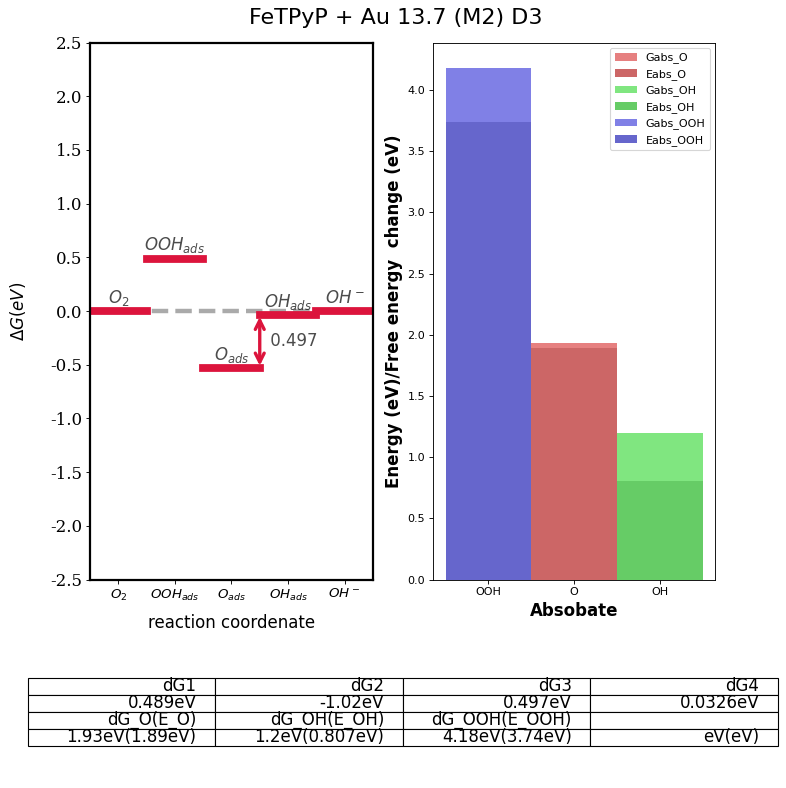

In [7]:
	# ========================== TPyP  ========================== #
	orr = OxigenReaction() # ========= FeTPyP + Au 13.7 D3 ========= # 
	orr.calculate(sys={'E':-826.487,'ZPE':0.0,'S':0.0}, sys_O={'E':-832.0498,'ZPE':0.07,'S':0.0},
				 sys_OH={'E':-836.5126,'ZPE':0.35,'S':0.0}, sys_OOH={'E':-841.034,'ZPE':0.43,'S':0.0}, sys_O2=None, 
							H2O={'E':-14.213,'ZPE':0.56,'S':0.67}, H2={'E':-6.76,'ZPE':0.27,'S':0.41}, Gb=-0.0)
	orr.plot_integrated('FeTPyP + Au 13.7 (M2) D3'.format(0))
	orr.summarise_steps()
	orr.summarise_absortion()